In [10]:
%cd /home/afischer/snakeclef-2024
! pip install -r requirements.txt

/home/afischer/snakeclef-2024
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 2.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 31.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 51.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 22.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.2 MB/s eta 0:00:0000:010

In [11]:
img_path = '/mnt/data/SnakeCLEF2023-small_size'
img_year = '2023'
img_species = 'Acanthophis_antarcticus'
img_file = '250558438.jpeg'

img_filename = '/'.join([img_path, img_year, img_species, img_file])
img_filename

'/mnt/data/SnakeCLEF2023-small_size/2023/Acanthophis_antarcticus/250558438.jpeg'

In [12]:
import os

os.listdir("/".join(img_filename.split('/')[:-1]))

['250558438.jpeg', '250558444.jpeg']

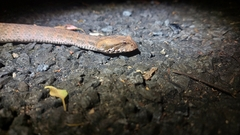

In [13]:
from PIL import Image

image = Image.open(img_filename)
image

In [14]:
import numpy as np
np.asarray(image).shape

(135, 240, 3)

In [15]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.PILToTensor()
])

img_tensor = transform(image)
img_tensor.shape

/home/afischer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([3, 135, 240])

In [30]:
import torch
from transformers import AutoImageProcessor, AutoModel

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')

In [33]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs['last_hidden_state']

outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

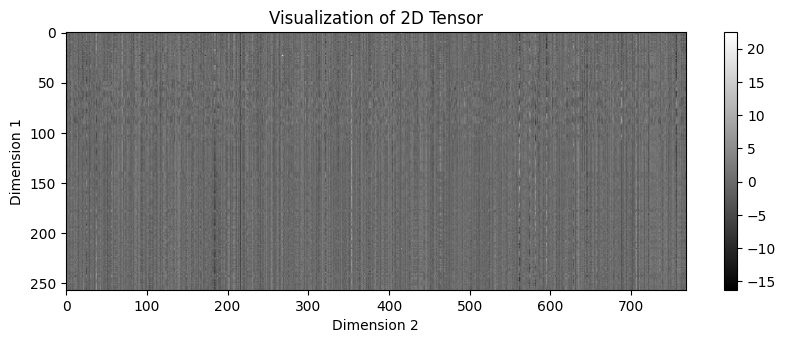

In [34]:
import matplotlib.pyplot as plt

# Remove the first dimension
tensor_2d = last_hidden_states.squeeze(0).detach()

# Calculate the aspect ratio
aspect_ratio = tensor_2d.shape[1] / tensor_2d.shape[0]

# Set figure size based on aspect ratio
plt.figure(figsize=(10, 10 / aspect_ratio))

# Plotting
plt.imshow(tensor_2d, aspect='auto', cmap='gray')
plt.colorbar()
plt.title('Visualization of 2D Tensor')
plt.xlabel('Dimension 2')
plt.ylabel('Dimension 1')
plt.show()


In [35]:
last_hidden_states.shape

torch.Size([1, 257, 768])

## Model Performance Optimization 
HuggingFace [recommends](https://huggingface.co/docs/transformers/model_doc/dinov2) optimizing the model using JIT tracing:

"The model can be traced using torch.jit.trace which leverages JIT compilation to optimize the model making it faster to run. Note this still produces some mis-matched elements and the difference between the original model and the traced model is of the order of 1e-4."

In [22]:
# We have to force return_dict=False for tracing
model.config.return_dict = False

with torch.no_grad():
    traced_model = torch.jit.trace(model, [inputs.pixel_values])
    traced_outputs = traced_model(inputs.pixel_values)

print((last_hidden_states - traced_outputs[0]).abs().max())

tensor(0.0001, grad_fn=<MaxBackward1>)
